In [10]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import phate
import scprep
import os
from collections import defaultdict

In [11]:
colors = {'mustard': '#E1AD01', 'berry': '#AC2F3D', 'teal': '#216E76', 'purple':'#502A4F', 'forest': '#065535', 'light forest': '#519167',
          'light yellow': '#E3BC81', 'light berry': '#c7505d', 'light teal': '#81ABA1', 'light purple': '#95636E', 'black': '#000000', 'gray':'#808080', 'sienna': 'sienna', 'white':'white', 'pink': 'palevioletred', 'brown':'brown'}

names = ['GSPA_QR', 'DiffusionEMD', 'MAGIC', 'Signals', 'GSPA', 'GAE_att_Ggene',
       'GAE_noatt_Ggene', 'Node2Vec_Ggene', 'GFMMD', 'Eigenscore','SIMBA', 'siVAE']

clist = np.array(['black', 'light yellow', 'purple', 'forest', 'mustard', 'teal',
         'berry', 'gray', 'light purple', 'light forest', 'light teal', 'sienna', 'white', 'pink', 'brown'])

conv = dict(zip(names, clist))

In [12]:
clist = np.array([conv[x] for x in names])

In [13]:
results = pd.DataFrame(columns=range(4))
for model in names:
    out = pd.read_csv(f'./results/{model}/spearmanr_101112_hyperparameters.txt', sep=' ', header=None)
    mask = (out[0].str.startswith('10')) | (out[0].str.startswith('11')) | (out[0].str.startswith('0_')) | (out[0].str.startswith('1_'))  | (out[0].str.startswith('7')) | (out[0].str.startswith('8'))
    out = out[mask]
    out[3] = model
    results = pd.concat((results, out))
    results.reset_index(drop=True, inplace=True)
results.columns = ['run', 'metric', 'Spearman', 'model']

In [14]:
names = np.array(names)
vals = results.groupby('model').mean('metric').loc[names]
names = names[np.argsort(vals, axis=0)].flatten()
clist = clist[np.argsort(vals, axis=0)].flatten()

/tmp/ipykernel_1716907/540511016.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=results['model'],


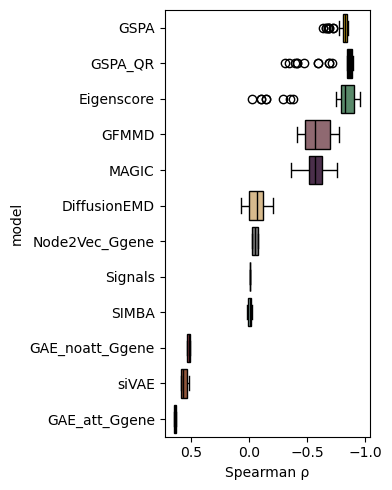

In [15]:
fig, ax = plt.subplots(figsize=(4,5))
sns.boxplot(y=results['model'],
            x=results['Spearman'].astype(float), 
            palette=[colors[c] for c in clist],
            order=names,
            ax=ax)
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel(f'Spearman ρ')
plt.tight_layout()

if not os.path.exists(f'./figures/'):
    os.makedirs(f'./figures/')
    
fig.savefig(f'./figures/localization_uniform_1011_hyperparameters.png', dpi=200)

In [16]:
results['name'] = ['_'.join(x[1:]) for x in results['run'].str.split('_')]
results['run'] = [x[0] for x in results['run'].str.split('_')]
#results['Spearman'] = -1* results['Spearman'] 

In [17]:
ranks = defaultdict(list)

In [18]:
for name in set(results['name'].unique()) - set(['sqrt', '', 'log']):
    if 'sqrt' in name:
        vals = results[(results['name'] == name) | (results['name'] == 'sqrt')].groupby('model').mean('metric')
    else:
        vals = results[(results['name'] == name) | (results['name'] == '') | (results['name'] == 'log')].groupby('model').mean('metric')
    order = vals.index[np.argsort(vals, axis=0)[::-1]].flatten()
    for i,name in enumerate(order):
        ranks[name].append(i)

/tmp/ipykernel_1716907/2123333056.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  order = vals.index[np.argsort(vals, axis=0)[::-1]].flatten()
/tmp/ipykernel_1716907/2123333056.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  order = vals.index[np.argsort(vals, axis=0)[::-1]].flatten()
/tmp/ipykernel_1716907/2123333056.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  order = vals.index[np.argsort(vals, axis=0)[::-1]].flatten()
/tmp/ipykernel_1716907/2123333056.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be rem

In [19]:
ranks = pd.DataFrame(ranks)
ranks['graph'] = list(set(results['name'].unique()) - set(['sqrt', '', 'log']))
ranks.index = ['linear']*len(ranks)

In [20]:
two_branches=np.array(['GSPA_QR', 'GSPA', 'GFMMD', 'Eigenscore', 'DiffusionEMD', 'MAGIC', 'SIMBA', 'Signals', 'Node2Vec_Ggene', 'siVAE', 'GAE_noatt_Ggene', 'GAE_att_Ggene'])
order_index_map = {element: idx for idx, element in enumerate(two_branches)}
two_branches_indices = [order_index_map[element] for element in ranks.columns[:-1]]

In [21]:
three_branches=np.array(['GSPA_QR', 'DiffusionEMD', 'GSPA', 'GFMMD', 'MAGIC', 'SIMBA', 'Eigenscore', 'Node2Vec_Ggene', 'Signals', 'siVAE', 'GAE_noatt_Ggene', 'GAE_att_Ggene'])
order_index_map = {element: idx for idx, element in enumerate(three_branches)}
three_branches_indices = [order_index_map[element] for element in ranks.columns[:-1]]

In [22]:
ranks.loc['two_branches'] = two_branches_indices + ['knn_5_adaptive_sqrt']
ranks.loc['three_branches'] = three_branches_indices + ['knn_5_adaptive_sqrt']

In [23]:
ranks.to_csv('uniform_results/localization_ranks.csv')

OSError: Cannot save file into a non-existent directory: 'uniform_results'

In [ ]:
with_cell_graph = ranks[['GSPA_QR', 'GSPA', 'MAGIC', 'Eigenscore', 'DiffusionEMD', 'GFMMD']].values.flatten()
without_cell_graph = ranks[['Signals', 'Node2Vec_Ggene', 'GAE_noatt_Ggene', 'GAE_att_Ggene', 'SIMBA', 'siVAE']].values.flatten()

In [ ]:
fig = plt.figure()
sns.stripplot(x=['with_graph']*len(with_cell_graph) + ['without_cell_graph']*len(without_cell_graph), 
              y=list(with_cell_graph) + list(without_cell_graph))
fig.savefig('figures/localization_jitterplot_ranks.png', dpi=500)

In [ ]:
with_cell_graph.mean()

In [ ]:
without_cell_graph.mean()